In [1]:
import pybedtools as pbt
import numpy as np
from tqdm import tqdm
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, wilcoxon, ttest_ind, chisquare
from ipyparallel import Client
from statsmodels.sandbox.stats.multicomp import multipletests

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

## The objective here is to check whether the expectation scores are higher in g4-chipSeq peaks compared to random peaks and how this compares to G4 motifs detected by QuadParser

### We start by first extracting peak sequences and creating random peaks and saving them

In [45]:
_ = pbt.BedTool('../data/chip_seq_g4/rhh175_ChIPwthacat_704_502_entst_26082015_peaks.narrowPeak').saveas(
    '../data/chip_seq_g4/hacat_peaks_rep1.bed')
_ = pbt.BedTool('../data/chip_seq_g4/rhh_25cyc_BG4_12082015_peaks.narrowPeak').saveas(
    '../data/chip_seq_g4/hacat_peaks_rep2.bed')

In [61]:
!bedtools intersect \
    -a ../data/chip_seq_g4/hacat_peaks_rep1.bed \
    -b ../data/chip_seq_g4/hacat_peaks_rep2.bed | \
    awk 'BEGIN{OFS="\t"}{print $1,$2,$3}' > ../data/chip_seq_g4/common_peaks.bed

In [121]:
!wc -l ../data/chip_seq_g4/common_peaks.bed

11691 ../data/chip_seq_g4/common_peaks.bed


In [123]:
peaks_bed = pbt.BedTool('../data/chip_seq_g4/common_peaks.bed')
genome_info_fn = '/home/parashar/scratch/hg19_resource/hg19.genome'
for i in tqdm(range(1000)):
    out_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.bed' % i
    _ = peaks_bed.shuffle(g=genome_info_fn, chrom=True).saveas(out_fn)

100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


In [120]:
def get_chrom_seq(chrom):
    fasta_base_dir ='/home/parashar/scratch/hg19_resource/chromosomes'
    chrom_seq = "".join([x.rstrip('\n') for x in
               open("%s/%s.fa" % (fasta_base_dir, chrom)).readlines()[1:]]).upper()
    return chrom_seq

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_name_idx = {x:n for n,x in enumerate(chroms)}
chrom_seqs = DVIEW.map_sync(get_chrom_seq, chroms)

In [124]:
def extract_seq(bed_file, out_name):
    chrom_wise_intervals = {}
    for chrom in chroms:
        chrom_wise_intervals[chrom] = []
    with open (bed_file) as h:
        for l in h:
            c = l.split('\t')
            if c[0] in chroms:
                chrom_wise_intervals[c[0]].append((int(c[1]), int(c[2])))
    
    sequences = []
    for chrom in chroms:
        for span in chrom_wise_intervals[chrom]:
            sequences.append(chrom_seqs[chrom_name_idx[chrom]][span[0]:span[1]])
    with open(out_name, 'w') as OUT:
        OUT.write("\n".join(sequences))
    return None

_ = extract_seq('../data/chip_seq_g4/common_peaks.bed',
            '../data/chip_seq_g4/common_peaks.seq')
for i in tqdm(range(1000)):
    in_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.bed' % i
    out_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.seq' % i
    _ = extract_seq(in_fn, out_fn)

100%|██████████| 1000/1000 [01:03<00:00, 16.67it/s]


### Lets now calculate the G4Hunter scores of the peaks and random peaks

In [125]:
%%writefile G4Hunter_chip_seq_wrapper.py

import os

script = '/home/parashar/scratch/quadcomb/scripts/G4Hunter.r'
in_fn = '../data/chip_seq_g4/common_peaks.seq'
out_fn = '../data/chip_seq_g4/g4hunter_scores.txt'
bsub = "bsub -n 2 -q debugq -J peaks -o g4hunter_chipseq_logs/peaks.log"
cmd = '%s Rscript %s %s %s' % (bsub, script, in_fn, out_fn)
os.system(cmd)

for i in range(1000):
    in_fn = '../data/chip_seq_g4/random_regions/random_peaks_%d.seq' % i
    out_fn = '../data/chip_seq_g4/g4hunter_random/random_%d.txt' % i
    bsub = "bsub -n 2 -q debugq -J %d -o g4hunter_chipseq_logs/%d.log" % (i, i)
    cmd = '%s Rscript %s %s %s' % (bsub, script, in_fn, out_fn)
    os.system(cmd)

Overwriting G4Hunter_chip_seq_wrapper.py


In [126]:
! mkdir g4hunter_chipseq_logs
! python G4Hunter_chip_seq_wrapper.py
clear_output()

### Now lets load and the expectation scores and calculate the Expectation scores in each of the G4-Chip and random genomic location of equivalent span. Takes about 1 min for 100 random iterations with 30 cores

In [132]:
def calc_score_in_span(chrom):
    import numpy as np
    
    def load_scores(strand):
        in_dir = '/home/parashar/scratch/quadcomb/data/snipr'
        fn = '%s/%s_%s_scores.npy' % (in_dir, chrom, strand)
        return np.load(fn)

    def calc(fn):
        ac = 0
        scores = []
        with open(fn) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                if c[0] == chrom:
                    p = pos[int(c[1]):int(c[2])]
                    n = neg[int(c[1]):int(c[2])]
                    if p.max() >= 185 or n.max() >= 185:
                        ac += 1
                    scores.append(p+n)
        return scores, ac
    
    pos = load_scores('positive')
    neg = load_scores('negative')
    in_dir = '/home/parashar/scratch/quadcomb/data/chip_seq_g4'
    peak_s, above_cutoff = calc('%s/common_peaks.bed' % in_dir)
    rand_s = []
    for i in range(1000):
        in_fn = '%s/random_regions/random_peaks_%d.bed' % (in_dir, i)
        rand_s.append(calc(in_fn))
    return peak_s, rand_s, above_cutoff

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(calc_score_in_span, chroms)

peak_scores = []
random_scores = [[] for x in range(1000)]
random_above_cutoff = [0 for x in range(1000)]
above_cutoff = []
for i in res:
    peak_scores.extend(i[0])
    for n,j in enumerate(i[1]):
        random_scores[n].extend(j[0])
        random_above_cutoff[n] += j[1]
    above_cutoff.append(i[2])
print (sum(above_cutoff))
np.save('../data/chip_seq_g4/sniprq_peak_scores', np.array(peak_scores))
np.save('../data/chip_seq_g4/sniprq_random_region_scores',  np.array(random_scores))
np.save('../data/chip_seq_g4/sniprq_random_region_ac',  np.array(random_above_cutoff))

8125


### Now lets calculate the number of G4 motifs of various configurations that occur in Peaks and random regions

In [2]:
from QuadFinder import QuadMotifFinder

In [39]:
def get_chrom_seq(chrom):
    fasta_base_dir ='/home/parashar/scratch/hg19_resource/chromosomes'
    chrom_seq = "".join([x.rstrip('\n') for x in
               open("%s/%s.fa" % (fasta_base_dir, chrom)).readlines()[1:]]).upper()
    return chrom_seq, len(chrom_seq)

def get_chrom_interval(chrom):
    intervals = []
    with open('../data/chip_seq_g4/common_peaks.bed') as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            if c[0] == chrom:
                intervals.append((int(c[1]), int(c[2])))
    return intervals

def get_random_intervals(chrom_len, intervals):
    rand_intervals = []
    for i in intervals:
        d = i[1] - i[0]
        r = np.random.randint(chrom_len-d)
        rand_intervals.append((r, r + d))
    return rand_intervals

def get_g4_motifs(sequences):
    q = QuadMotifFinder(sequences, stem=3, loop_start=1, loop_stop=25, greedy=True,
                        bulge=5, is_seq=True, strands=['+', '-'], verbose=False)
    q.run()
    return len(set([x.split('\t', 1)[0] for x in q.resNov]))
    

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']

peak_motifs = 0
num_reps = 100
random_motifs = [0 for x in range(num_reps)]
for chrom in chroms:
    chrom_seq, chrom_len = get_chrom_seq(chrom)
    intervals = np.array(get_chrom_interval(chrom))
    
    peak_motifs += get_g4_motifs([chrom_seq[i[0]:i[1]].upper() for i in intervals])
    for i in tqdm(range(num_reps), desc=chrom):
        select_intervals = intervals[np.random.randint(0, len(intervals), 100)]
        rand_intervals = get_random_intervals(chrom_len, select_intervals)
        random_motifs[i] += get_g4_motifs([chrom_seq[i[0]:i[1]].upper()
                                           for i in rand_intervals])
    clear_output()
    break

### Time to plot data

In [113]:
peak_sniprq = np.load('../data/chip_seq_g4/sniprq_peak_scores.npy')
random_sniprq = np.load('../data/chip_seq_g4/sniprq_random_region_scores.npy')
peak_ac = 8125
random_ac = np.load('../data/chip_seq_g4/sniprq_random_region_ac.npy')

In [121]:
mean_peak = np.array([np.mean(x) for x in peak_sniprq])
mean_random = []
for i in random_sniprq:
    mean_random.extend([np.mean(x) for x in i])
mean_random = np.array(mean_random)

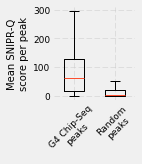

(3.0802313147212731e-15, 7.7064696564602573e-12, 4.276794115131298e-06)

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([mean_peak, mean_random], sym='', widths=[0.5, 0.5],)
ax.set_ylabel('Mean SNIPR-Q\nscore per peak', fontsize=10)
ax.set_xticklabels(['G4 Chip-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/g4_chip_seq_sniprq.svg', transparent=True, edgecolor='none')
plt.show()

pvals = []
for i in range(5000):
    pvals.append(mannwhitneyu(
        [mean_peak[np.random.randint(len(mean_peak))] for x in range(100)],
        [mean_random[np.random.randint(len(mean_random))] for x in range(100)])[1])
corrected_pvals = multipletests(pvals, alpha=0.05, method='holm',
                                is_sorted=False, returnsorted=False)[1]
np.median(pvals), np.median(corrected_pvals), 0.05/mean_peak.shape[0]

In [123]:
np.median(mean_peak)/np.median(mean_random)

19.817908117752008

In [124]:
max_peak = np.array([np.max(x) for x in peak_sniprq])
max_random = np.array([[np.max(y) for y in x] for x in random_sniprq.T]).T
max_peak.shape, max_random.shape

((11691,), (1000, 11691))

100%|██████████| 1000/1000 [00:00<00:00, 1975.13it/s]


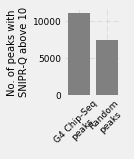

10 [11036, 7429.777] 1.4853743255 5.22062634577e-10


In [154]:
x = [1,2]
for cutoff in [10, 50, 100, 185, 200, 500, 700, 800]:
    fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))
    max_peak_ac = len(max_peak[max_peak > cutoff])
    max_random_ac = [len(x[x > cutoff]) for x in max_random]
    y = [max_peak_ac, np.mean(max_random_ac)]
    ax.bar(x, y, yerr=[0, np.std(max_random_ac)],
           color='grey')
    vals = []
    for i in tqdm(range(1000)):
        rand_ints = [np.random.randint(len(max_peak)) for x in range(100)]
        a = max_peak[rand_ints]
        b = max_random[i][[rand_ints]]
        vals.append((len(a[a > cutoff]), len(b[b > cutoff])))
    vals = np.array(vals).T
        
#     corrected_pvals = multipletests(pvals, alpha=0.05, method='holm',
#                                 is_sorted=False, returnsorted=False)[1]
    ax.set_ylabel('No. of peaks with\nSNIPR-Q above %d' % cutoff, fontsize=10)
    ax.set_xticklabels(['', 'G4 Chip-Seq\npeaks', 'Random\npeaks'],
                       rotation=45, fontsize=10, ha='center')
    clean_axis(ax)
    plt.tight_layout()
    plt.savefig('../images/g4_chip_seq_above_cutoff%d.svg' % cutoff,
                transparent=True, edgecolor='none')
    plt.show()
    print (cutoff, y, y[0]/y[1], np.median(corrected_pvals))
    break

In [161]:
ks_2samp(vals[0], vals[1])

Ks_2sampResult(statistic=1.0, pvalue=0.0)

In [160]:
from scipy.stats import ks_2samp

## G4Hunter

In [12]:
def load_hunter(fn):
    s = []
    with open(fn) as h:
        next(h)
        for l in h:
            c = l.rstrip('\n').split('\t')
            s.append(float(c[1]))
    s = np.array(s)
    return s

peak_hunter_scores = load_hunter('../data/chip_seq_g4/g4hunter_scores.txt')
random_hunter_scores = []
for i in tqdm(range(1000)):
    in_fn = '../data/chip_seq_g4/g4hunter_random/random_%d.txt' % i
    random_hunter_scores.append(load_hunter(in_fn))
random_hunter_scores = np.array(random_hunter_scores)

100%|██████████| 1000/1000 [00:48<00:00, 23.81it/s]


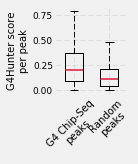

(6.1814365163786932e-05, 0.15457914575771728, 4.276794115131298e-06)

In [13]:
boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))
a = np.abs(peak_hunter_scores)
b = np.abs(random_hunter_scores.flatten())
ax.boxplot([a, b], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

ax.set_ylabel('G4Hunter score\nper peak', fontsize=10)
clean_axis(ax)
ax.set_xticklabels(['G4 Chip-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)

plt.tight_layout()
plt.savefig('../images/g4_chip_seq_hunter_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chip_seq_hunter_scores.svg', transparent=True, edgecolor='none')
plt.show()
pvals = []
for i in range(5000):
    pvals.append(mannwhitneyu([a[np.random.randint(len(a))] for x in range(100)],
                 [b[np.random.randint(len(b))] for x in range(100)])[1])
corrected_pvals = multipletests(pvals, alpha=0.05, method='holm',
                                is_sorted=False, returnsorted=False)[1]
np.median(pvals), np.median(corrected_pvals), 0.05/a.shape[0]

In [14]:
np.median(a)/np.median(b)

1.8518518518518521

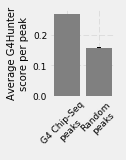

[0.26800514498332051, 0.15864944665982381] 1.68929139449 Power_divergenceResult(statistic=7.5424728473817426, pvalue=1.0)


In [15]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))

a = a.mean()
b = np.array([np.abs(random_hunter_scores[x]).mean() for x in range(100)])

x = [1,2]
y = [a, b.mean()]
ax.bar(x, y, yerr=[0, b.std()], color='grey')
ax.set_ylabel('Average G4Hunter\n' + 'score per peak', fontsize=10)
ax.set_xticklabels(['', 'G4 Chip-Seq\npeaks', 'Random\npeaks'],
                   rotation=45, fontsize=10, ha='center')
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/g4_chip_seq_hunter_scores_bootstrap.png',
            dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chip_seq_hunter_scores_bootstrap.svg',
            transparent=True, edgecolor='none')
plt.show()
print (y, y[0]/y[1], chisquare([a], b))

In [16]:
a = np.abs(peak_hunter_scores)
b = np.abs(random_hunter_scores[0])

print (len(a[a > 0.29]))
print (len(b[b > 0.29]))

4044
1731


## G4 Motifs

In [45]:
peak_motifs = np.load('../data/chip_seq_g4/peaks_motifs.npy')
random_motifs = np.load('../data/chip_seq_g4/random_peaks_motifs.npy')
peak_motifs.shape, random_motifs.shape

((24, 2), (24, 2, 100))

In [78]:
peak_motifs[: ,1]

array([1219,  888,  654,  142,  521,  436,  622,  537,  532,  513,  680,
        557,  180,  470,  462,  453,  718,  175,  616,  437,   67,  276,
        139,    0])

In [77]:
random_motifs[: , 1 ,: ].mean(axis=1)

array([ 854.76,  650.74,  474.81,   92.63,  367.56,  307.41,  463.16,
        392.28,  355.67,  385.96,  519.  ,  420.61,  102.33,  301.81,
        295.63,  334.76,  599.7 ,  119.65,  527.7 ,  347.77,   33.42,
        166.05,   94.28,    0.  ])

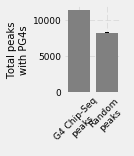

[11294, 8207.6900000000005] 1.37602662869 Power_divergenceResult(statistic=3431.1844279818615, pvalue=0.0)


In [72]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))

a = peak_motifs[:, 1].sum()
b = random_motifs.sum(axis=0)[1]

x = [1,2]
y = [a, b.mean()]
ax.bar(x, y, yerr=[0, b.std()], color='grey')
ax.set_ylabel('Total peaks\nwith PG4s', fontsize=10)
ax.set_xticklabels(['', 'G4 Chip-Seq\npeaks', 'Random\npeaks'],
                   rotation=45, fontsize=10, ha='center')
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/g4_chip_seq_g4_motifs_25_3.png',
            dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chip_seq_g4_motifs_25_3.svg',
             transparent=True, edgecolor='none')
plt.show()
print (y, y[0]/y[1], chisquare([a], b[:3]))

In [25]:
random_motifs

array([  151.8,   644.1,  1211.2,  3195.9,  6401.4,  7938.5])